In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

In [2]:
base_artifacts = Path.cwd().resolve().parents[1] / 'CausalI2I_artifacts'
raw_results = pd.read_csv(base_artifacts / 'Datasets' / 'Simulation' / 'simulation_evaluated.csv')

In [3]:
new_names = {
    'cosine_similarity': 'Cosine',
    'correlation': 'Pearson',
    'diff_of_conditionals': 'DoC',
    'jacard_index': 'Jaccard',
    'sasrec_score': 'SASRec'
}
raw_results = raw_results.rename(columns=new_names)

raw_results = raw_results[raw_results['ATE'] < 0.99].copy()
raw_results['causal_link'] = (raw_results['causal_effect'] > 0).astype(int)

raw_results['STE'] = raw_results['ATE'] / raw_results['STD']
raw_results['ABLT/STD'] = raw_results['ABLT'] / raw_results['STD_ABLT']

baselines = ["ATE", "STE", "ABLT", "ABLT/STD", "Cosine", "Pearson", "DoC", "Jaccard"]

In [4]:
Ks = [10, 20, 50, 100, 200, 500, 1000]

vals2plot = {col: None for col in baselines}
for col in baselines:
    col_choises = raw_results.sort_values(by=col, ascending=False)['causal_link'].values
    vals2plot[col] = {K: np.sum(col_choises[:K]) for K in Ks}
total_positives = np.sum(raw_results['causal_link'].values)

summary = {}
for K in Ks:
    summary[('Precision@K (%)', f'K={K}')] = {
        col: 100 * vals2plot[col][K] / K
        for col in baselines}
for K in Ks:
    summary[('Recall@K (%)', f'K={K}')] = {
        col: 100 * vals2plot[col][K] / total_positives
        for col in baselines}
    
summary_df = pd.DataFrame(summary).map(lambda x: f'{x:.2f}')
summary_df

Precision@K (%)                                              \
                    K=10    K=20    K=50  K=100  K=200  K=500 K=1000   
ATE                50.00   70.00   84.00  89.00  86.50  68.60  44.70   
STE                90.00   95.00   96.00  98.00  98.50  75.60  44.70   
ABLT               60.00   70.00   78.00  82.00  73.50  54.40  36.10   
ABLT/STD           90.00   95.00   98.00  94.00  78.00  50.00  33.00   
Cosine             80.00   70.00   56.00  58.00  44.00  29.80  21.00   
Pearson           100.00  100.00  100.00  96.00  83.50  55.80  36.10   
DoC               100.00   95.00   92.00  69.00  57.50  41.20  29.20   
Jaccard            90.00   90.00   78.00  70.00  57.00  40.20  28.20   

         Recall@K (%)                                          
                 K=10  K=20  K=50  K=100  K=200  K=500 K=1000  
ATE              0.82  2.29  6.86  14.54  28.27  56.05  73.04  
STE              1.47  3.10  7.84  16.01  32.19  61.76  73.04  
ABLT             0.98  2.29  6.37  13.40  24.02  44.44  58.99  
ABLT/STD         1.47  3.10  8.01  15.36  25.49  40.85  53.92  
Cosine           1.31  2.29  4.58   9.48  14.38  24.35  34.31  
Pearson          1.63  3.27  8.17  15.69  27.29  45.59  58.99  
DoC              1.63  3.10  7.52  11.27  18.79  33.66  47.71  
Jaccard          1.47  2.94  6.37  11.44  18.63  32.84  46.08

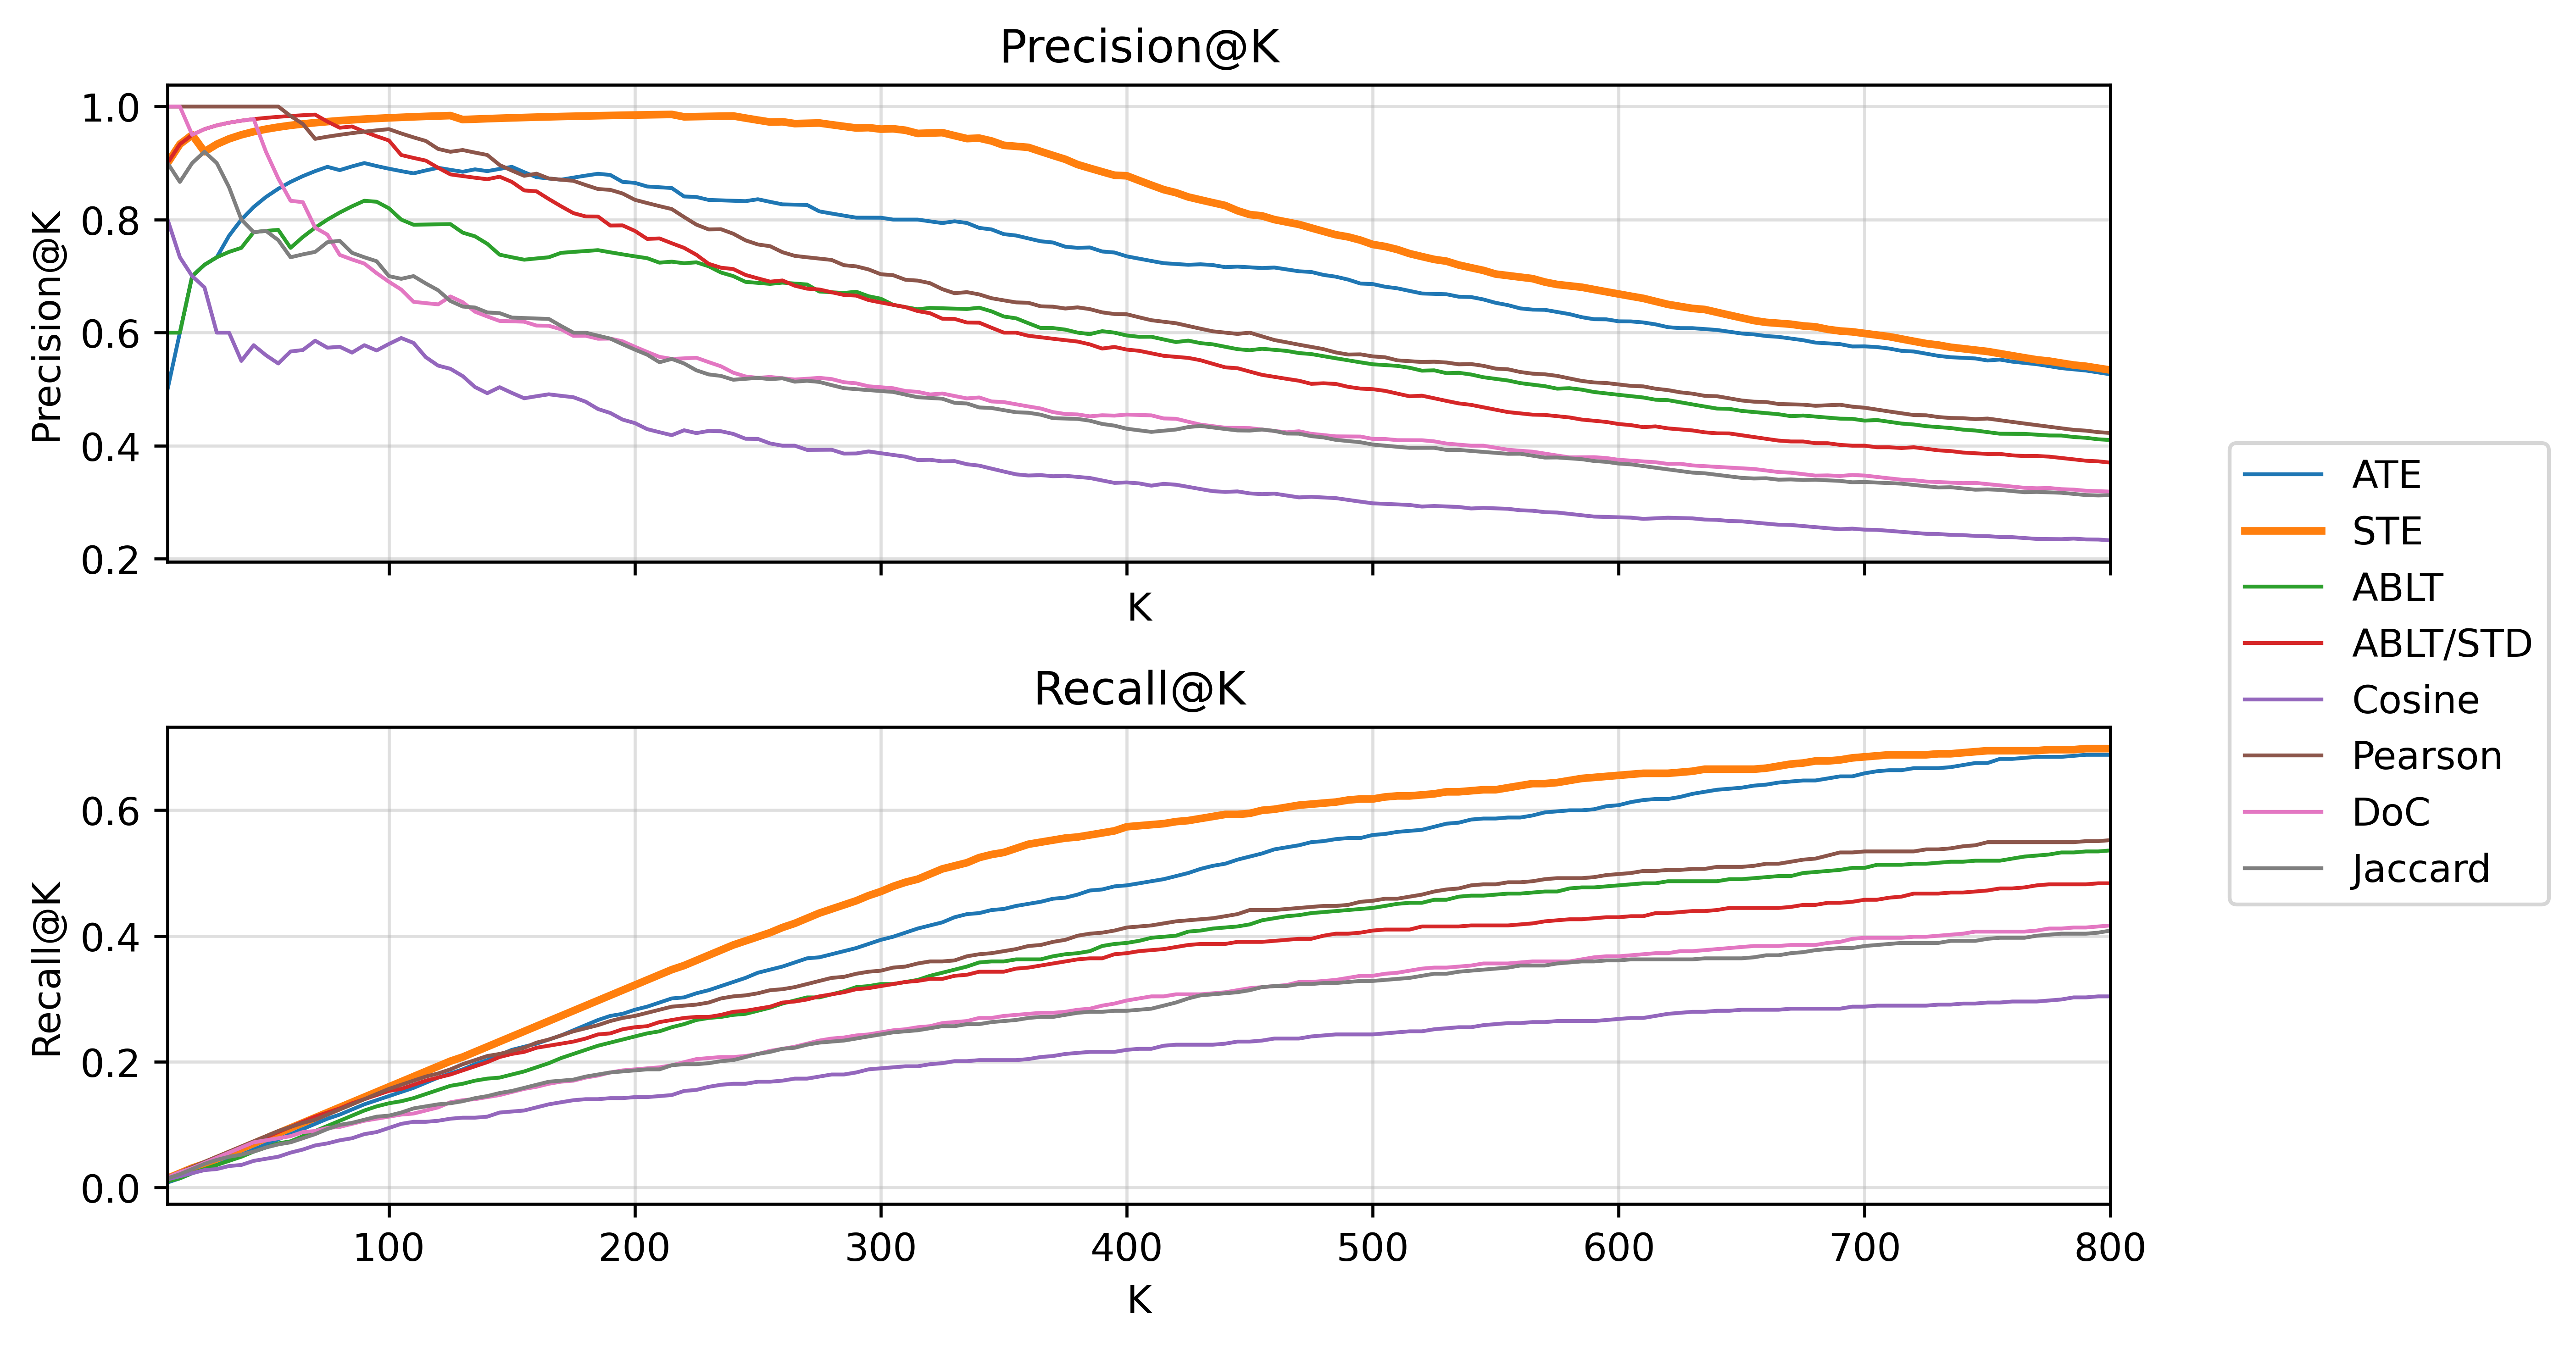

In [5]:
Ks = np.arange(10, 801, step=5)
total_positives = (raw_results['causal_link'] > 0).sum()

fig, axes = plt.subplots(2, 1, figsize=(8, 5), dpi=600, sharex=True)

# --- store curves and means ---
precision_curves = {}
recall_curves = {}
mean_precision = {}
mean_recall = {}

# ---- compute curves ----
for col in baselines:
    col_ser = raw_results.sort_values(by=col, ascending=False)['causal_link']

    precision_vals = np.array([col_ser[:K].sum() / K for K in Ks])
    recall_vals = np.array([col_ser[:K].sum() / total_positives for K in Ks])

    precision_curves[col] = precision_vals
    recall_curves[col] = recall_vals

    mean_precision[col] = precision_vals.mean()
    mean_recall[col] = recall_vals.mean()

# ---- select best baselines by mean ----
best_precision_col = max(mean_precision, key=mean_precision.get)
best_recall_col = max(mean_recall, key=mean_recall.get)

# ---- plot Precision@K ----
for col in baselines:
    axes[0].plot(
        Ks,
        precision_curves[col],
        linewidth=2 if col == best_precision_col else 1,
        label=col
    )

# ---- plot Recall@K ----
for col in baselines:
    axes[1].plot(
        Ks,
        recall_curves[col],
        linewidth=2 if col == best_recall_col else 1,
        label=col
    )

# ---- Titles ----
axes[0].set_title("Precision@K")
axes[1].set_title("Recall@K")

# ---- Labels ----
axes[0].set_ylabel("Precision@K")
axes[1].set_ylabel("Recall@K")

# ---- Grid + limits ----
for ax in axes:
    ax.set_xlabel("K")
    ax.grid(alpha=0.4)
    ax.set_xlim([Ks[0], Ks[-1]])

# ---- Shared legend ----
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    bbox_to_anchor=(1.01, 0.5),
    loc="center left"
)

plt.tight_layout()
plt.savefig(
    base_artifacts / 'Figures' / 'simulation' / 'precision_recall_synthetic.png', 
    bbox_inches='tight'
)
plt.show()


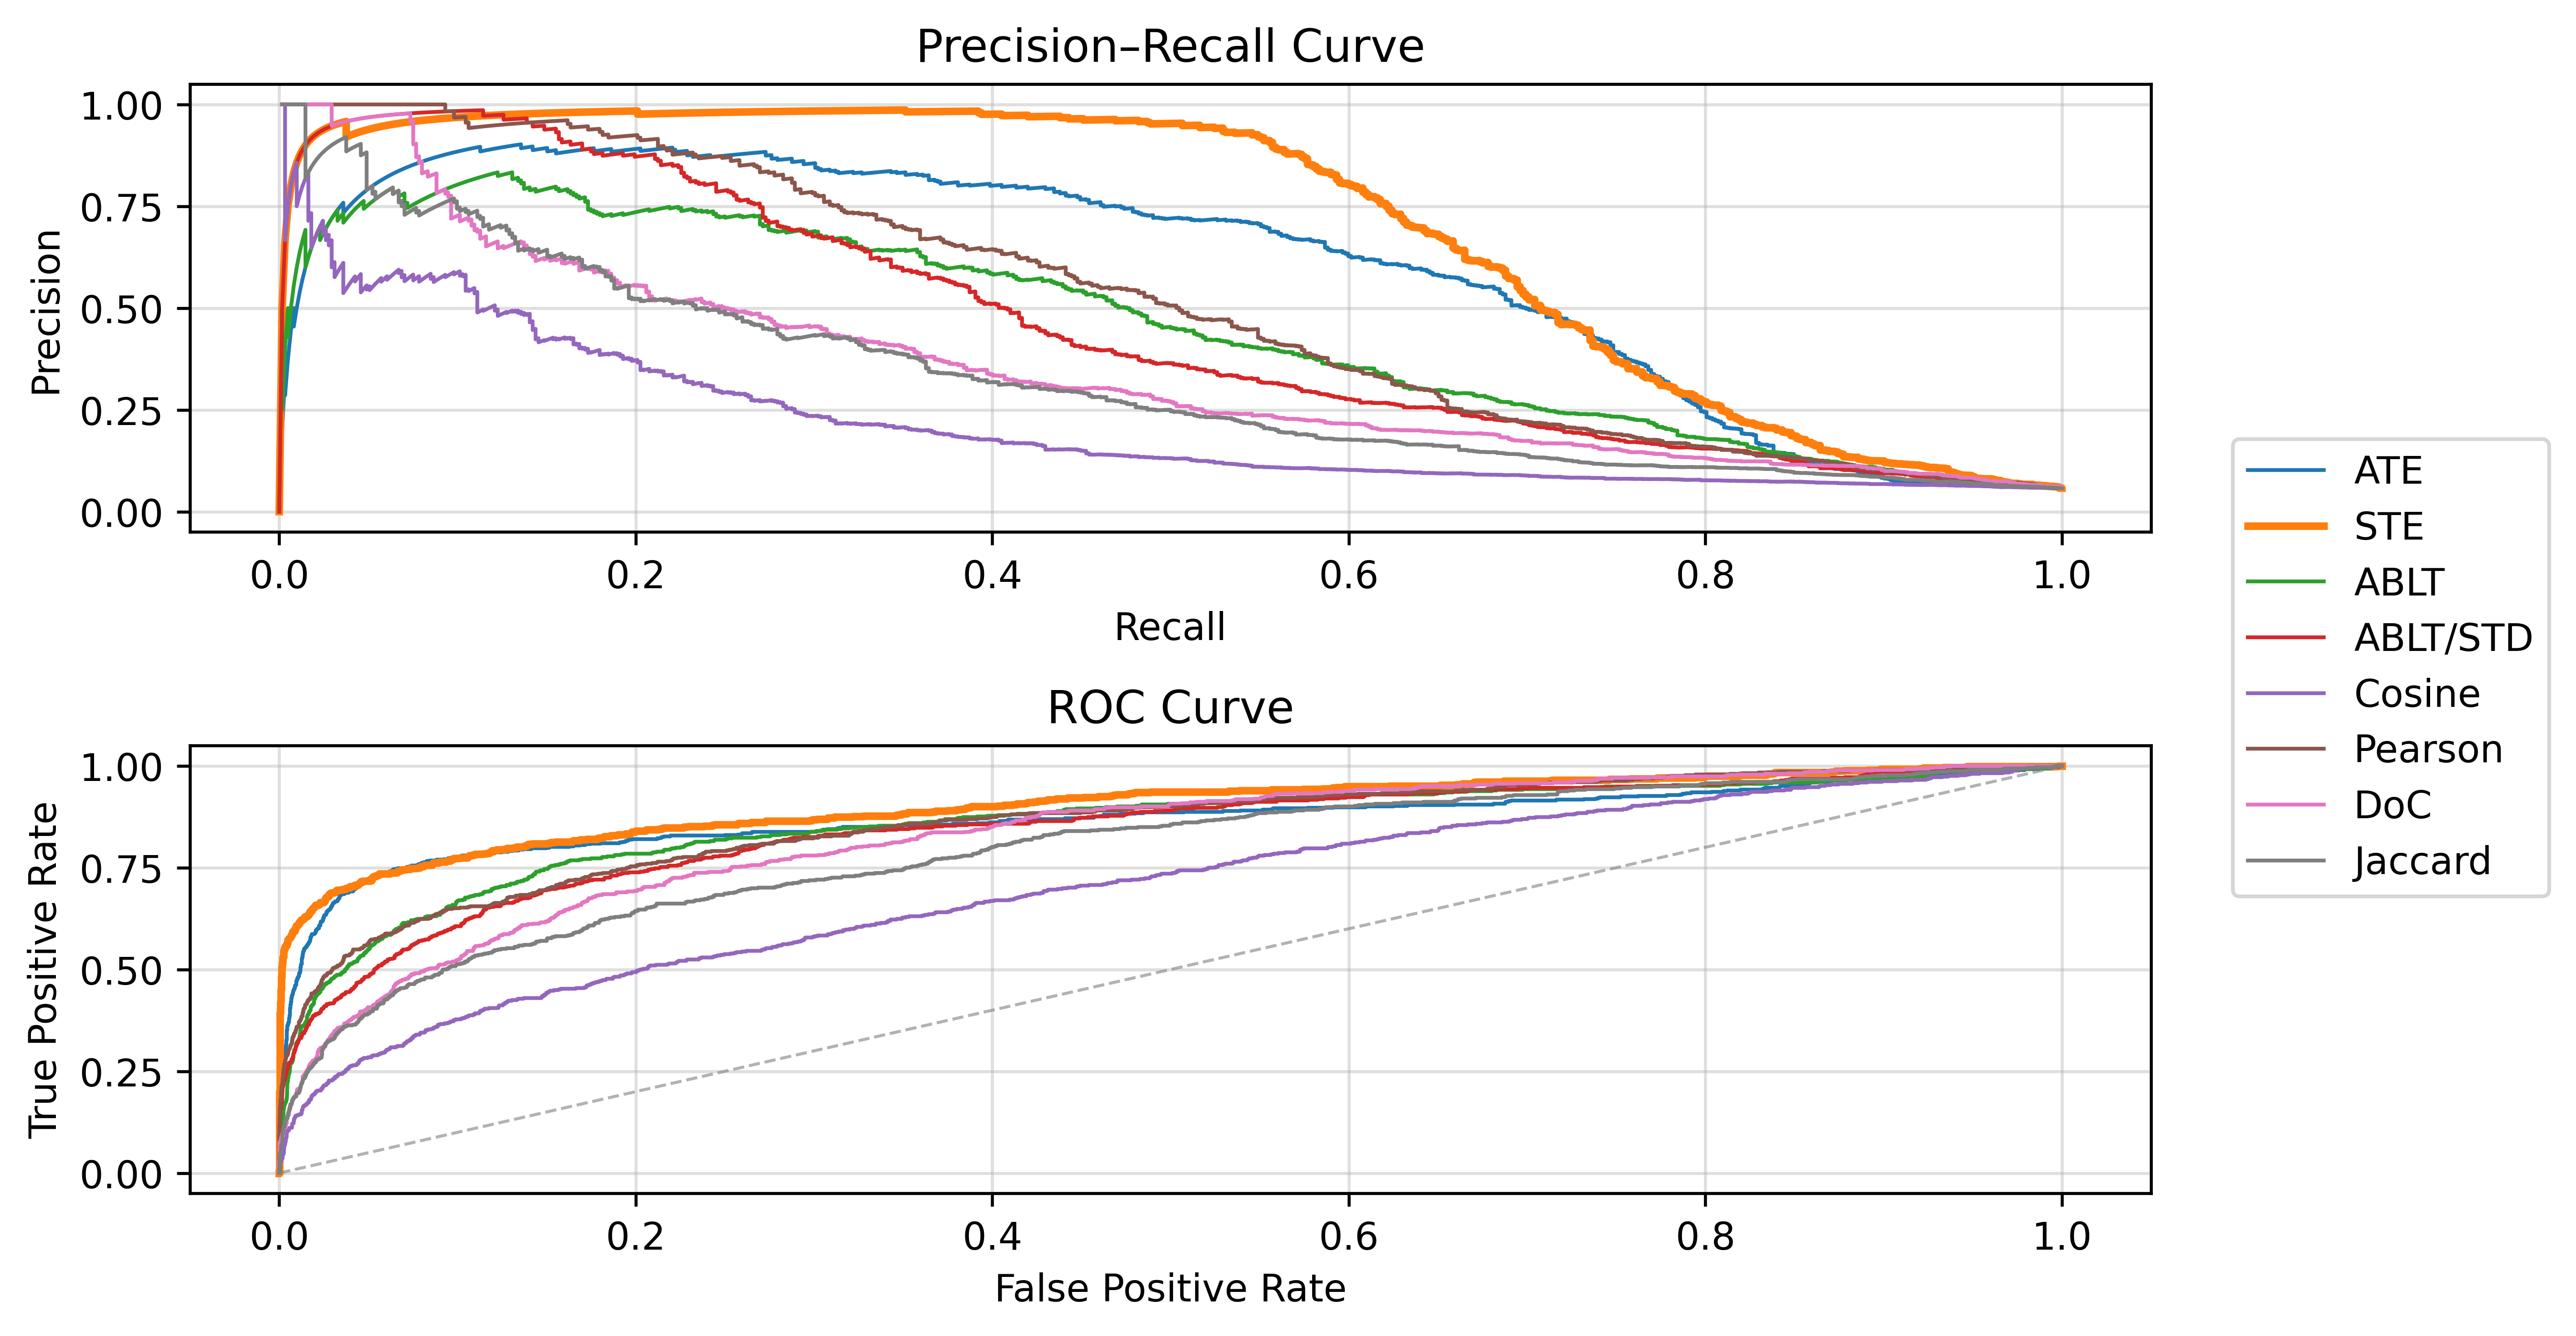

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), dpi=600, sharex=False)

y_true = raw_results['causal_link'].values

# --- store curves and scores ---
pr_curves = {}
roc_curves = {}
ap_scores = {}
auc_scores = {}

# ---- compute curves + scores ----
for col in baselines:
    y_score = raw_results[col].values

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    pr_curves[col] = (recall[:-1], precision[:-1])
    roc_curves[col] = (fpr, tpr)

    ap_scores[col] = average_precision_score(y_true, y_score)
    auc_scores[col] = roc_auc_score(y_true, y_score)

# ---- select best baselines ----
best_pr_col = max(ap_scores, key=ap_scores.get)
best_roc_col = max(auc_scores, key=auc_scores.get)

# ---- plot Precision–Recall ----
for col in baselines:
    recall, precision = pr_curves[col]
    axes[0].plot(
        recall,
        precision,
        linewidth=2 if col == best_pr_col else 1,
        label=col
    )

# ---- plot ROC ----
for col in baselines:
    fpr, tpr = roc_curves[col]
    axes[1].plot(
        fpr,
        tpr,
        linewidth=2 if col == best_roc_col else 1,
        label=col
    )

# ---- Titles ----
axes[0].set_title("Precision–Recall Curve")
axes[1].set_title("ROC Curve")

# ---- Labels ----
axes[0].set_ylabel("Precision")
axes[0].set_xlabel("Recall")

axes[1].set_ylabel("True Positive Rate")
axes[1].set_xlabel("False Positive Rate")

# ---- Grid ----
for ax in axes:
    ax.grid(alpha=0.4)
axes[1].plot([0, 1], [0, 1], ls="--", lw=0.8, color="grey", alpha=0.6)

# ---- Shared legend ----
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    bbox_to_anchor=(1.01, 0.5),
    loc="center left"
)

plt.tight_layout()
plt.savefig(
    base_artifacts / 'Figures' / 'simulation' / 'pr_roc_synthetic.png', 
    bbox_inches='tight'
)
plt.show()


In [7]:
ap_results = {}
auc_results = {}

summary = {}
y_true = raw_results['causal_link'].values
for col in baselines:
    y_score = raw_results[col].values
    ap = average_precision_score(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    auc_results[col] = auc
    summary[col] = {'AP': ap, 'AUC': auc}

summary_df = pd.DataFrame(summary).map(lambda x: f'{x:.3f}').T
summary_df


AP    AUC
ATE       0.598  0.868
STE       0.707  0.901
ABLT      0.454  0.856
ABLT/STD  0.462  0.841
Cosine    0.216  0.700
Pearson   0.519  0.856
DoC       0.355  0.827
Jaccard   0.329  0.791

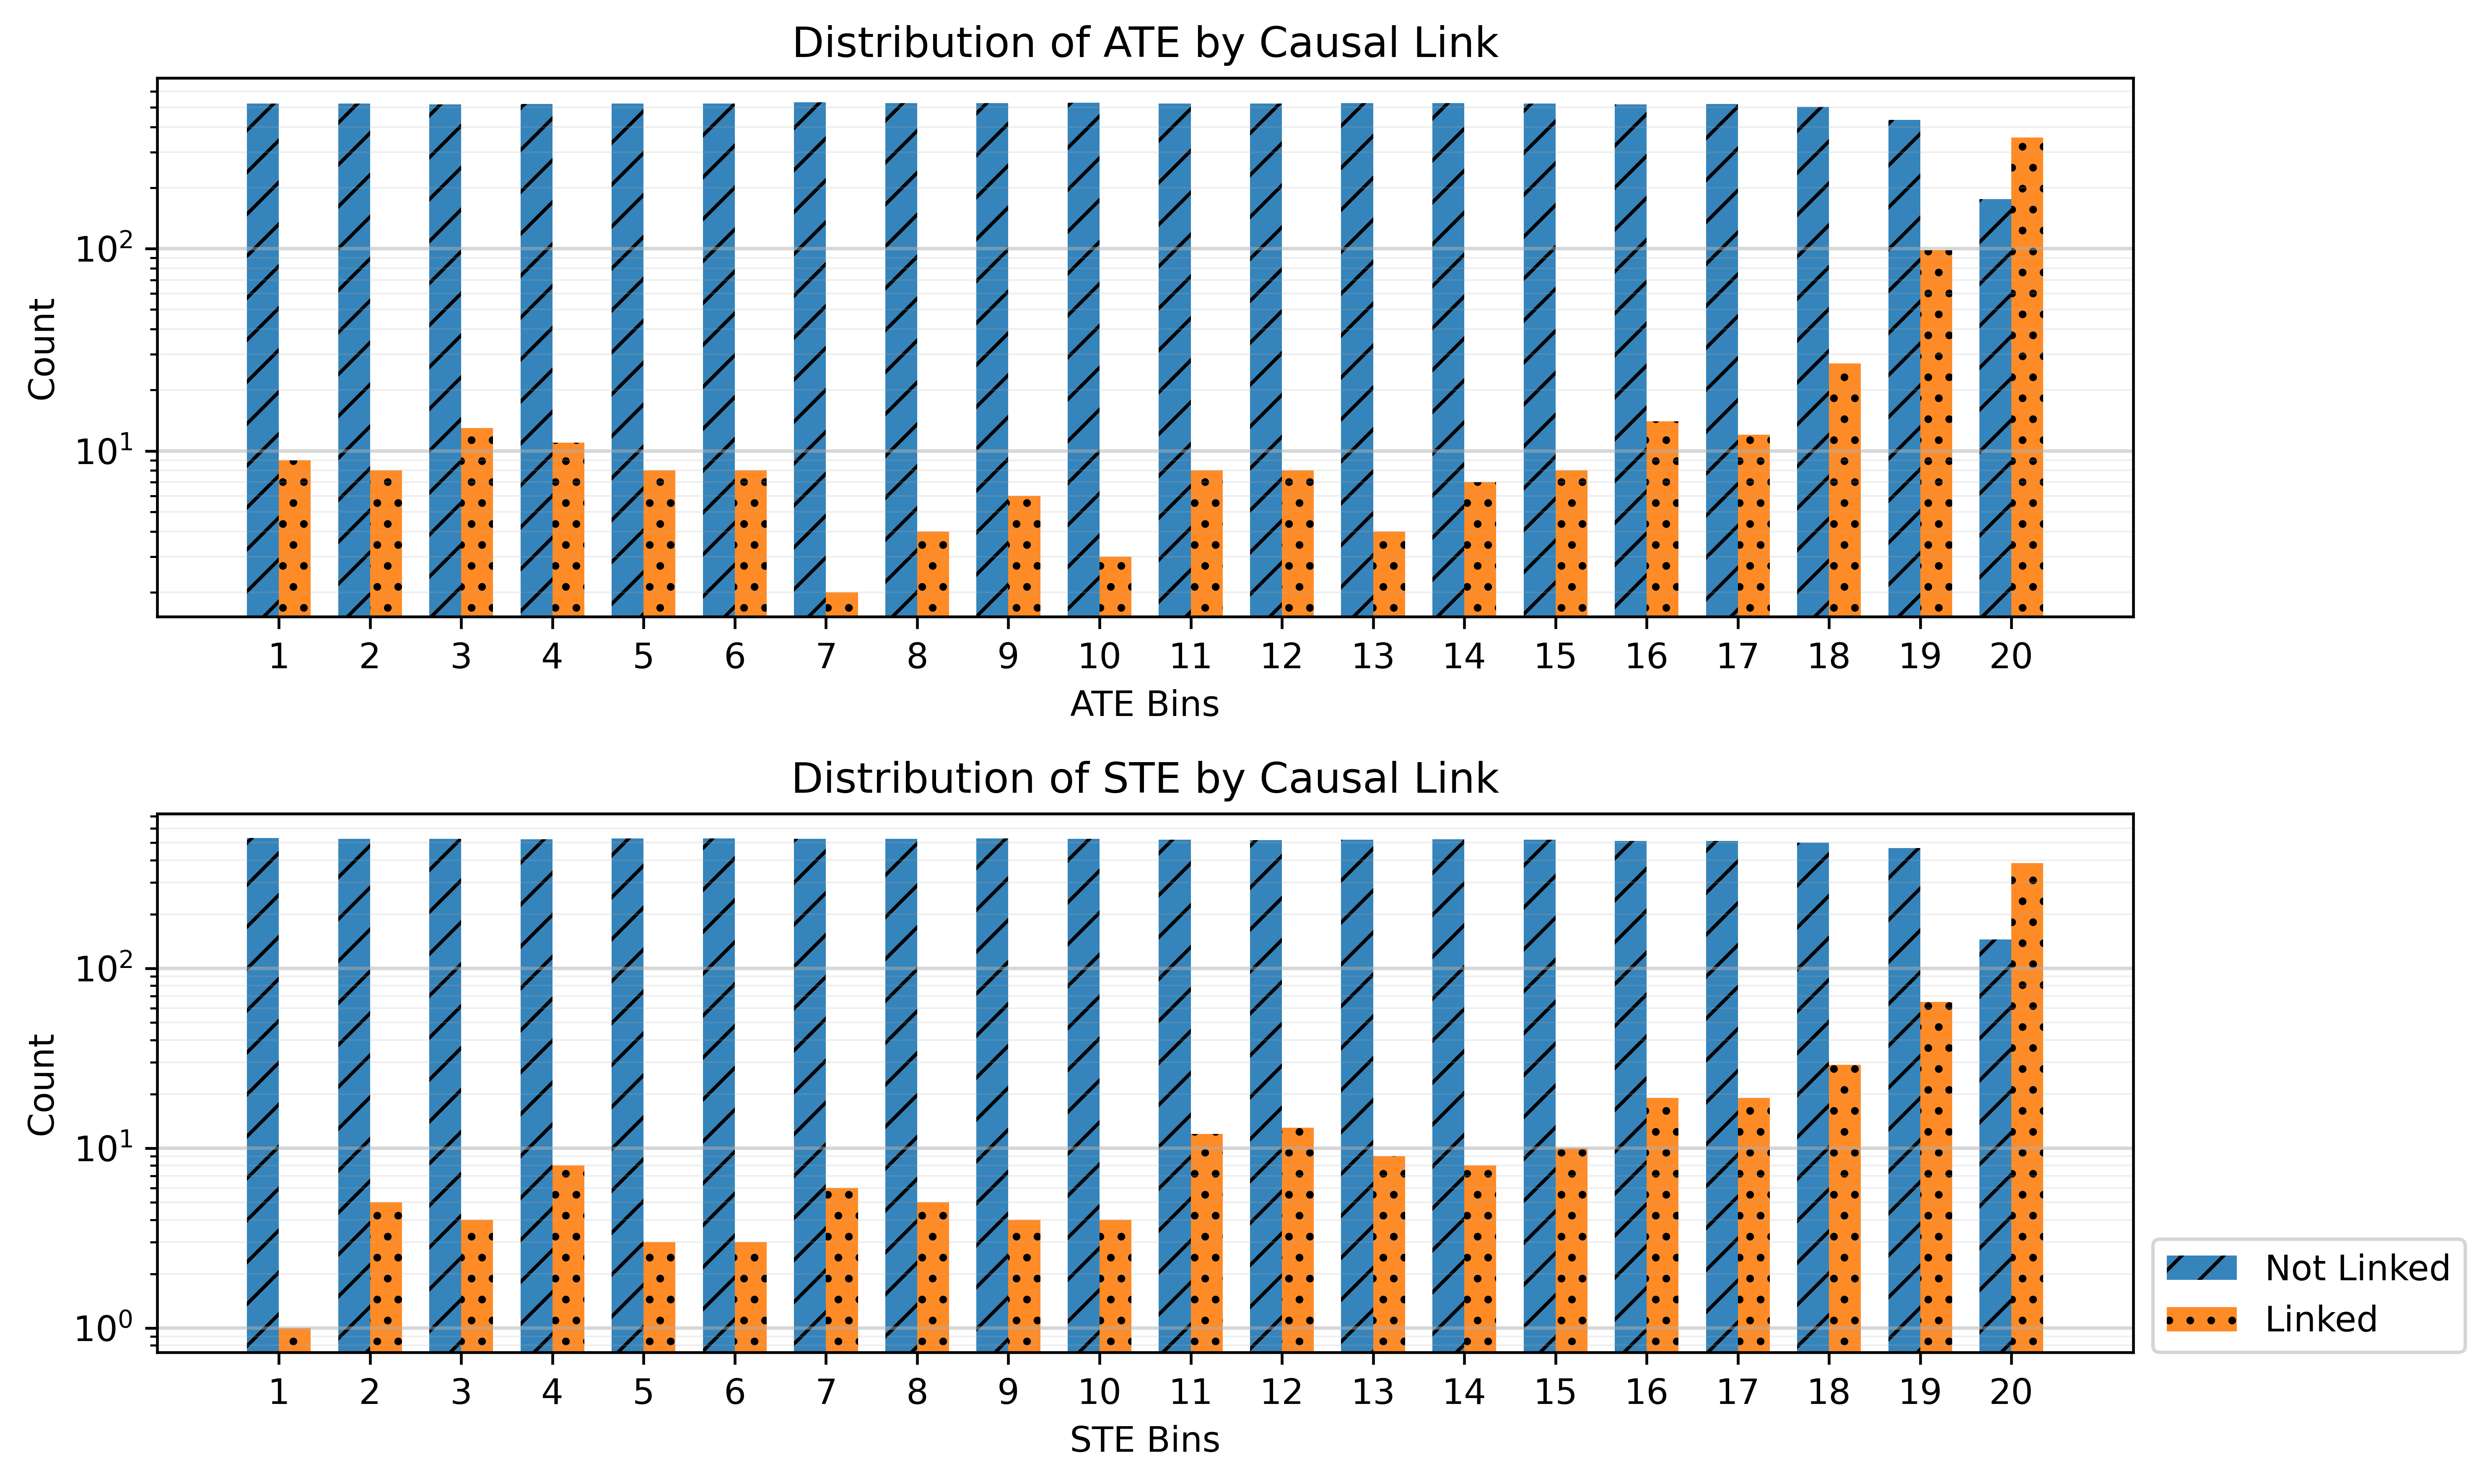

In [8]:
num_bins = 20
w = 0.35
hatches = ["//", ".."]

fig, axes = plt.subplots(2, 1, figsize=(10, 6), dpi=600)

for ax, metric in zip(axes, ["ATE", "STE"]):

    # Quantile bins for the current metric
    bins = np.quantile(
        raw_results[metric].values,
        np.arange(0, 1, 1 / num_bins)
    )

    df = raw_results[[metric, 'causal_link']].copy()
    df['metric_bin'] = np.digitize(df[metric], bins) - 1

    for link in [0, 1]:
        subset = df[df['causal_link'] == link]
        counts = subset['metric_bin'].value_counts().sort_index()

        ax.bar(
            counts.index + (link - 0.5) * w,
            counts.values,
            width=w,
            alpha=0.9,
            hatch=hatches[link],
            label='Linked' if link == 1 else 'Not Linked'
        )

    ax.set_xticks(range(num_bins))
    ax.set_xticklabels(range(1, num_bins + 1))
    ax.set_xlabel(f'{metric} Bins')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {metric} by Causal Link')

    ax.set_yscale('log')
    ax.grid(axis='y', which='major', alpha=0.5, linewidth=1)
    ax.grid(axis='y', which='minor', alpha=0.2, linewidth=0.5)

plt.legend(loc=(1.01, 0))
plt.tight_layout()
plt.savefig(
    base_artifacts / 'Figures' / 'simulation' / 'distribution_bins_synthetic.png', 
    bbox_inches='tight'
)
plt.show()


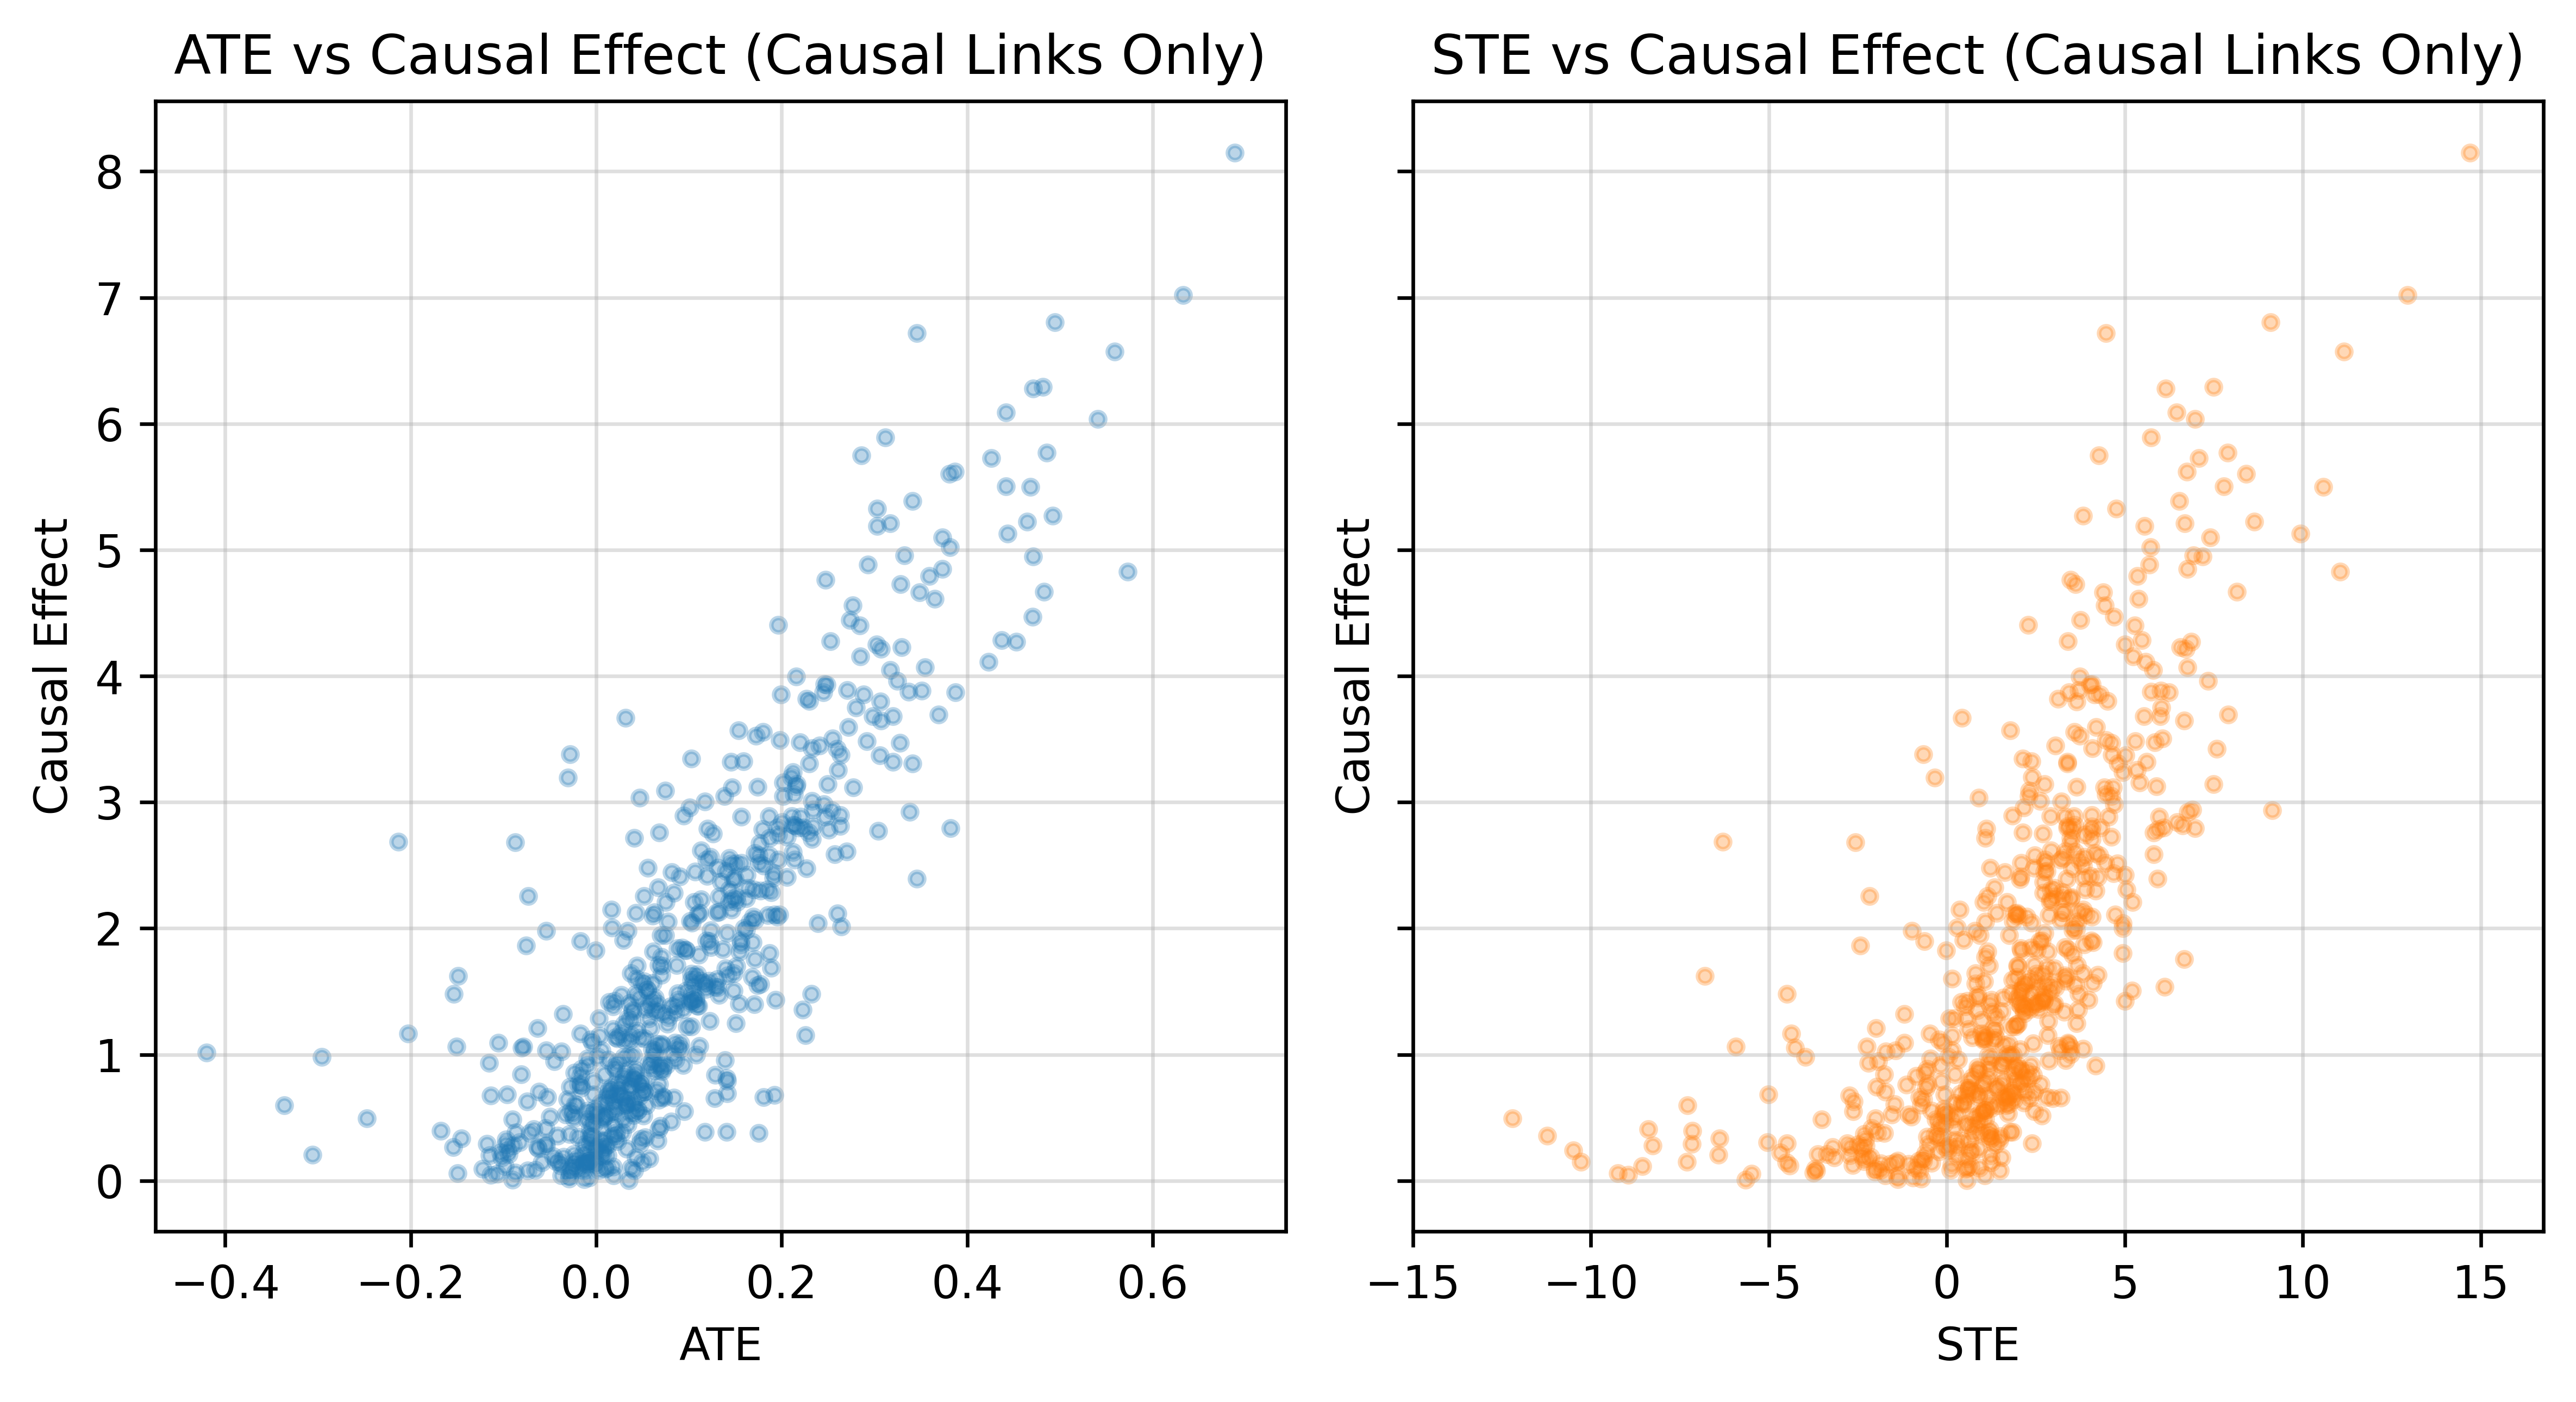

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4.5), dpi=600, sharey=True)

subset = raw_results[raw_results['causal_link'] == 1]
cols = ['ATE', 'STE']
colors = ['tab:blue', 'tab:orange']

for j in range(2):
    axes[j].scatter(
        subset[cols[j]],
        subset['causal_effect'],
        color=colors[j],
        alpha=0.3,
        s=10
    )
    axes[j].set_xlabel(cols[j])
    axes[j].set_ylabel('Causal Effect')
    axes[j].set_title(f'{cols[j]} vs Causal Effect (Causal Links Only)')
    axes[j].grid(alpha=0.4)
    axes[j].set_box_aspect(1)

axes[1].set_xlim(-15)
plt.tight_layout()
plt.savefig(
    base_artifacts / 'Figures' / 'simulation' / 'scatter_ate_vs_ste_causal_effect_(linked_only).png',
    bbox_inches='tight'
)
plt.show()
